In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
if False:
    from sklearn.datasets import fetch_openml
    
    df0 = fetch_openml(data_id=45106, as_frame=True)
    df = df0.data
    df["claim_nb"] = df0.target
else:
    df = pd.read_parquet("df.parquet")
df

,year,town,driver_age,car_weight,car_power,car_age,claim_nb
0,2018.0,1.0,51.0,1760.0,173.0,3.0,0
1,2019.0,1.0,41.0,1760.0,248.0,2.0,0
2,2018.0,1.0,25.0,1240.0,111.0,2.0,0
3,2019.0,0.0,40.0,1010.0,83.0,9.0,0
4,2018.0,0.0,43.0,2180.0,169.0,5.0,0
...,...,...,...,...,...,...,...
999995,2019.0,1.0,45.0,1090.0,62.0,2.0,0
999996,2019.0,1.0,45.0,1180.0,93.0,4.0,0
999997,2018.0,1.0,31.0,1060.0,57.0,1.0,0
999998,2019.0,1.0,28.0,1910.0,149.0,0.0,0


## Univariate description

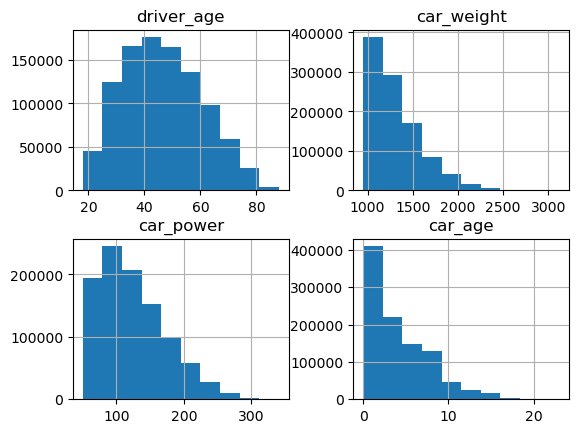

In [3]:
_ = df.hist(["driver_age", "car_weight", "car_power", "car_age"])

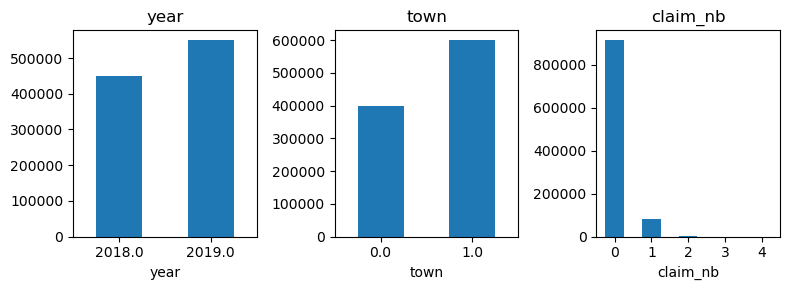

In [4]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=3)

for v, ax in zip(["year", "town", "claim_nb"], axes):
    df[v].value_counts(sort=False).sort_index().plot(kind="bar", ax=ax, rot=0, title=v)

plt.tight_layout()
plt.show()

## Data split

In [5]:
from sklearn.model_selection import train_test_split

y_train, y_test, X_train, X_test = train_test_split(
    df["claim_nb"], df.drop("claim_nb", axis=1), test_size=0.1, random_state=30
)

## LightGBM model (unconstrained)

In [24]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

dtrain = lgb.Dataset(X_train, label=y_train)

### Parameter tuning

We use 5-fold CV to manually select hyper-parameters. Of key importance is to select the number of boosting rounds not via grid search but rather via early-stopping on CV performance.

In [52]:
params = dict(
    learning_rate=0.05,
    objective="poisson",
    metric="poisson",
    num_leaves=7,
    min_child_samples=50,
    min_child_weight=0.001,
    colsample_bynode=0.8,
    subsample=0.8,
    reg_alpha=3,
    reg_lambda=5,
    verbose=-1,
)

if False:  # Set to True to re-run CV
    cvm = lgb.cv(
        params=params,
        train_set=dtrain,
        num_boost_round=2000,
        nfold=5,
        callbacks=[lgb.log_evaluation(period=10), lgb.early_stopping(20, verbose=0)],
    )

    num_rounds = len(cvm["valid poisson-mean"])
    num_rounds, cvm["valid poisson-mean"][num_rounds - 1]
else:
    num_rounds = 360

### Fit with best parameters

In [46]:
# model = lgb.train(params, train_set=dtrain, num_boost_round=num_rounds)
model = LGBMRegressor(n_estimators=num_rounds, **params, n_jobs=7)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 6
[LightGBM] [Info] Start training from score -2.414908


LGBMRegressor(colsample_bynode=0.8, learning_rate=0.05, metric='poisson',
              min_child_samples=50, n_estimators=350, n_jobs=7, num_leaves=7,
              objective='poisson', reg_alpha=3, reg_lambda=5, subsample=0.8)

### SHAP analysis

In [27]:
X_explain = X_train.sample(n=2000, random_state=937)

In [28]:
import shap

explainer = shap.Explainer(model)
shap_val = explainer(X_explain)

#### SHAP importance

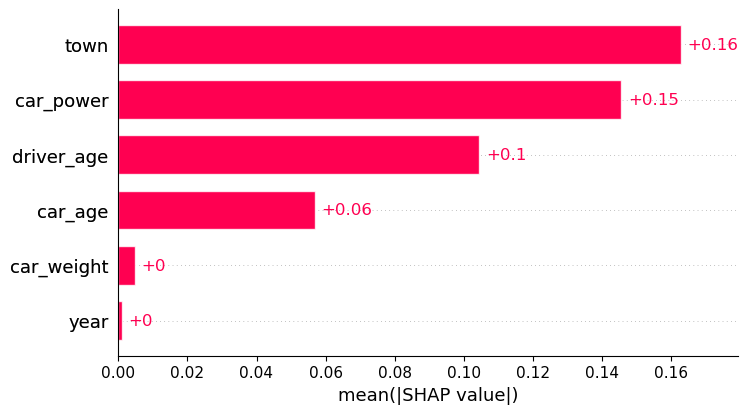

In [29]:
shap.plots.bar(shap_val)

#### SHAP dependence

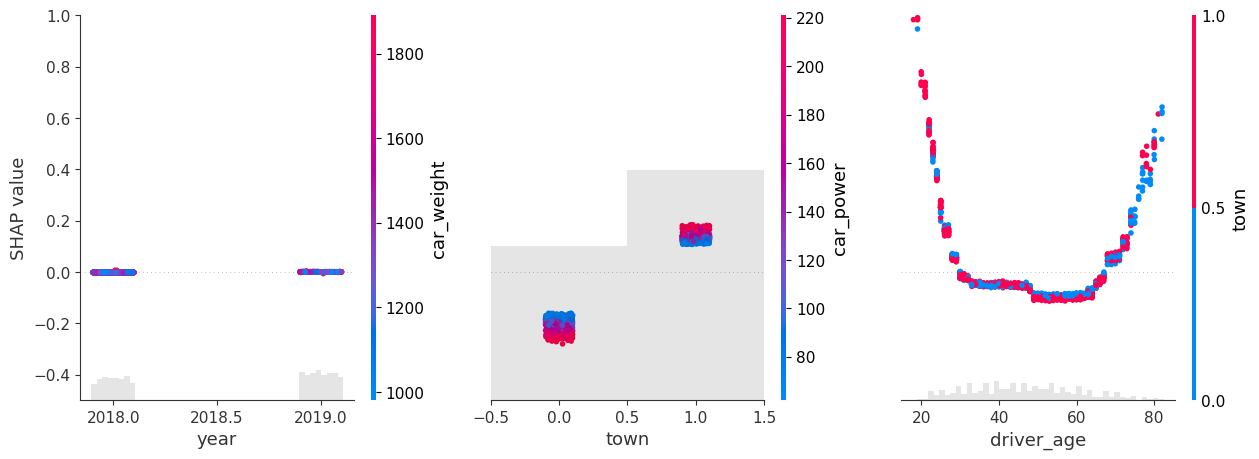

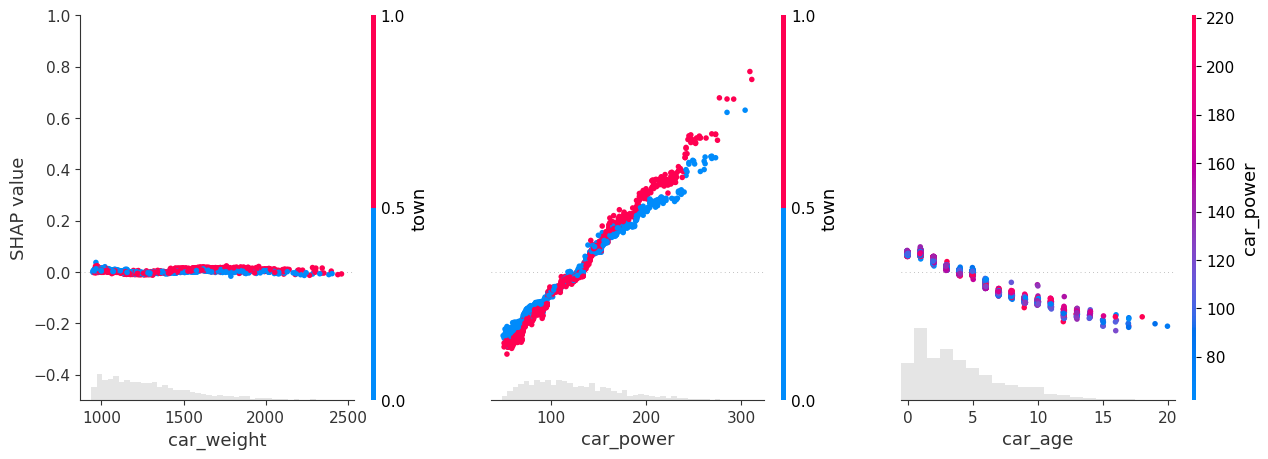

In [30]:
shap.plots.scatter(shap_val[:, 0:3], color=shap_val, ymin=-0.5, ymax=1)
shap.plots.scatter(shap_val[:, 3:], color=shap_val, ymin=-0.5, ymax=1)

## Interaction constraints

Let's keep `driver_age` and `car_age` additive, meaning that some trees use only `driver_age`, some only `car_age`, and the other trees use the rest. 

- Why could this be interesting?
- What is the difference to setting `max_depth = 1`?
- For simplicity, we don't select new hyper-parameters. But in practice, we should!

In [31]:
params_ic = params | {"interaction_constraints": [[2], [5], [0, 1, 3, 4]]}  # Mind the positions...
params_ic

{'learning_rate': 0.05,
 'objective': 'poisson',
 'metric': 'poisson',
 'num_leaves': 7,
 'min_data_in_leaf': 50,
 'min_sum_hessian_in_leaf': 0.001,
 'colsample_bynode': 0.8,
 'bagging_fraction': 0.8,
 'lambda_l1': 3,
 'lambda_l2': 5,
 'num_threads': 7,
 'interaction_constraints': [[2], [5], [0, 1, 3, 4]]}

In [32]:
model_ic = LGBMRegressor(n_estimators=num_rounds, **params_ic)
model_ic.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0

LGBMRegressor(bagging_fraction=0.8, colsample_bynode=0.8,
              interaction_constraints=[[2], [5], [0, 1, 3, 4]], lambda_l1=3,
              lambda_l2=5, learning_rate=0.05, metric='poisson',
              min_data_in_leaf=50, min_sum_hessian_in_leaf=0.001,
              n_estimators=350, num_leaves=7, num_threads=7,
              objective='poisson')

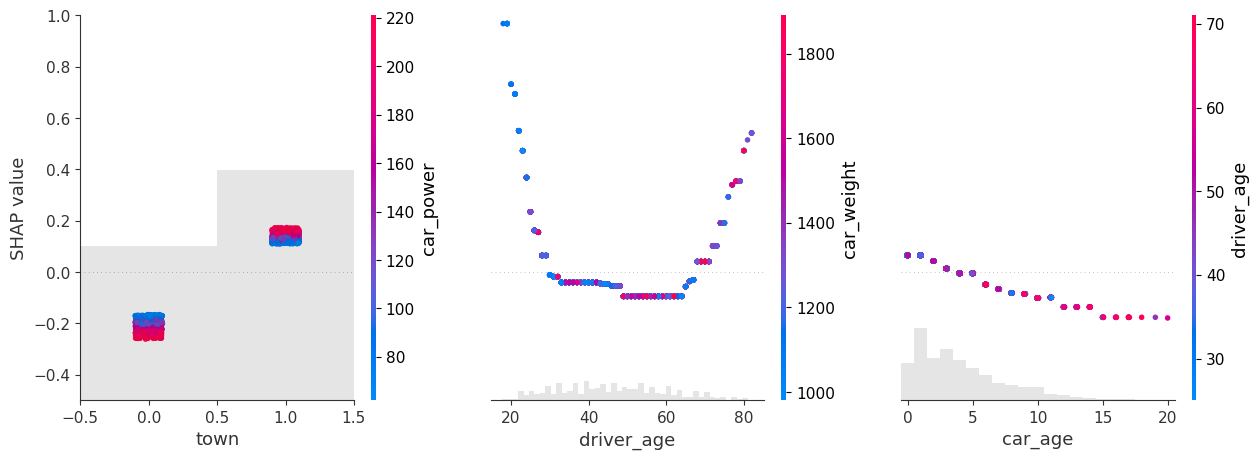

In [19]:
explainer_ic = shap.Explainer(model_ic)
shap_val_ic = explainer_ic(X_explain)

shap.plots.scatter(shap_val_ic[:, [1, 2, 5]], color=shap_val_ic, ymin=-0.5, ymax=1)

Note: Partial dependence plot of `driver_age`, on log scale, is identical. 

Show it via DALEX?

In [23]:
from sklearn.inspection import PartialDependenceDisplay
model_ic.is_fitted = True
PartialDependenceDisplay.from_estimator(model_ic, X_explain, ["car_age"])


InvalidParameterError: The 'estimator' parameter of partial_dependence must be an object implementing 'fit' and 'predict', an object implementing 'fit' and 'predict_proba' or an object implementing 'fit' and 'decision_function'. Got <lightgbm.basic.Booster object at 0x0000020766E3A7D0> instead.

## Monotone constraints

Let's force the prediction function to be monotonically increasing in the car power and monotonically decreasing in the car age, *ceteris paribus*. Note that this does not necessarily make sense. It is just a (relatively stupid) example. 

- Don't put too many monotonicity constraints: Are apartment prices really monotonically increasing in the number of rooms, keeping the living area fixed? No!
- In SHAP plots only visible for additive features.
- Otherwise need to check individual conditional expectation (ICE) plots (disaggregated partial dependence). TODO

In [80]:
params_mc = params_ic | {"monotone_constraints": [0, 0, 0, 0, 1, -1]}  # Mind the positions...
params_mc

{'learning_rate': 0.05,
 'objective': 'poisson',
 'metric': 'poisson',
 'num_leaves': 7,
 'min_data_in_leaf': 50,
 'min_sum_hessian_in_leaf': 0.001,
 'colsample_bynode': 0.8,
 'bagging_fraction': 0.8,
 'lambda_l1': 3,
 'lambda_l2': 5,
 'num_threads': 7,
 'interaction_constraints': [[2], [5], [0, 1, 3, 4]],
 'monotone_constraints': [0, 0, 0, 0, 1, -1]}

In [81]:
model_mc = lgb.train(params_mc, train_set=dtrain, num_boost_round=300)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 6
[LightGBM] [Info] Start training from score -2.414908


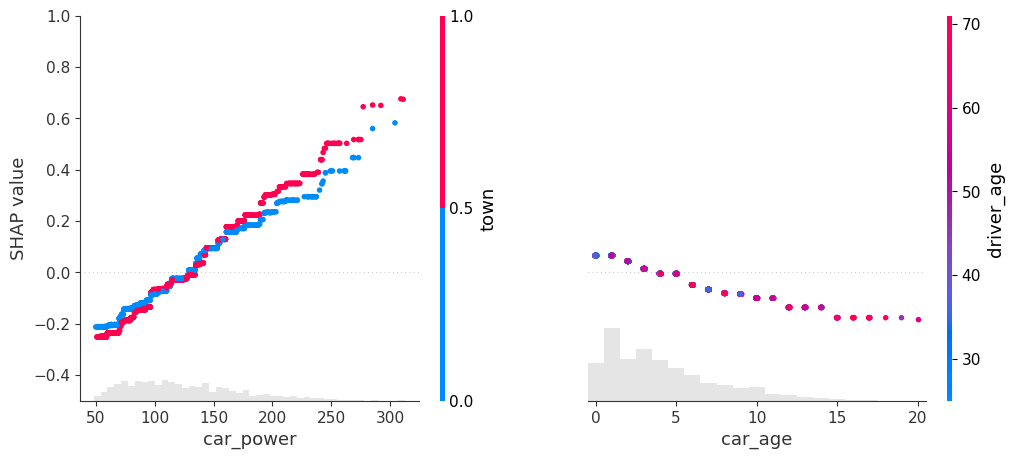

In [85]:
explainer_mc = shap.Explainer(model_mc)
shap_val_mc = explainer_mc(X_explain)

shap.plots.scatter(shap_val_mc[:, [4, 5]], color=shap_val_mc, ymin=-0.5, ymax=1)

## Monotonic constraints gone wrong

Define them correctly!

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 6
[LightGBM] [Info] Start training from score -2.414908


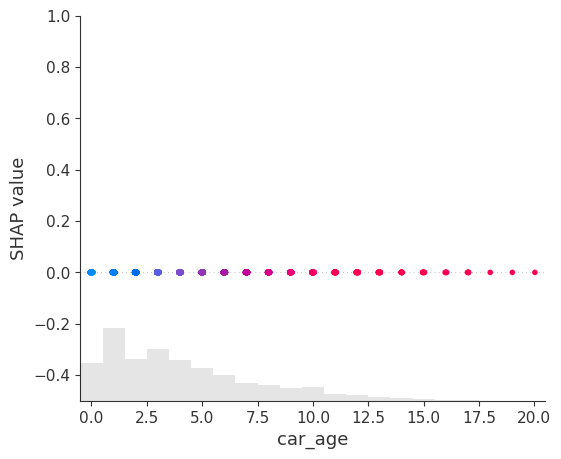

In [91]:
params_mc2 = params_ic | {"monotone_constraints": [0, 0, 0, 0, 1, 1]}  # Oops

model_mc2 = lgb.train(params_mc2, train_set=dtrain, num_boost_round=300)

explainer_mc2 = shap.Explainer(model_mc2)
shap_val_mc2 = explainer_mc2(X_explain)

shap.plots.scatter(shap_val_mc2[:, [5]], color=shap_val_mc2, ymin=-0.5, ymax=1)